In [1]:
!pip install mxnet d2l

In [2]:
import os
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [3]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [5]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

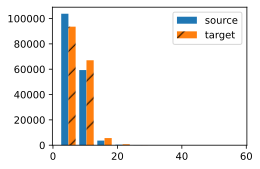

In [6]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [8]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [9]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

In [10]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [11]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.astype(np.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.astype(np.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: [[ 12 153   2   4   5   5   5   5]
 [ 66  60   2   4   5   5   5   5]]
valid lengths for X: [4 4]
Y: [[ 6  2  4  5  5  5  5  5]
 [96 72 31  2  4  5  5  5]]
valid lengths for Y: [3 5]


# Treinamento do modelo

In [12]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output)
        return output, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        encoder_output, hidden = self.encoder(src)
        output, hidden = self.decoder(trg, hidden)
        return output


In [13]:
vocab_size_src = len(src_vocab)
vocab_size_tgt = len(tgt_vocab)
embed_size = 256
hidden_size = 512

encoder = Encoder(vocab_size_src, embed_size, hidden_size)
decoder = Decoder(vocab_size_tgt, embed_size, hidden_size)

seq2seq_model = Seq2Seq(encoder, decoder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq2seq_model = seq2seq_model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=0.001)

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
    seq2seq_model.train()

    total_loss = 0
    for src, src_valid_len, trg, trg_valid_len in train_iter:
        optimizer.zero_grad()

        src = src.asnumpy()
        trg = trg.asnumpy()

        src = torch.tensor(src, dtype=torch.long).to(device)
        trg = torch.tensor(trg, dtype=torch.long).to(device)

        output = seq2seq_model(src, trg[:, :-1])

        loss = criterion(output.reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_iter)}')

Epoch 1, Loss: 0.13597711861428288
Epoch 2, Loss: 0.1348892564379047
Epoch 3, Loss: 0.1371872867791876
Epoch 4, Loss: 0.13432097427462955
Epoch 5, Loss: 0.13704617607261124
Epoch 6, Loss: 0.13169213542119826
Epoch 7, Loss: 0.1307580995504347
Epoch 8, Loss: 0.1379517435814832
Epoch 9, Loss: 0.1322843230951923
Epoch 10, Loss: 0.13718245142083704


In [28]:
batch_size = 64
num_steps = 10

test_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [29]:
seq2seq_model.eval()

with torch.no_grad():
    for src, src_valid_len, trg, trg_valid_len in test_iter:
        src = src.asnumpy()
        trg = trg.asnumpy()

        src = torch.tensor(src, dtype=torch.long).to(device)
        trg = torch.tensor(trg, dtype=torch.long).to(device)

        output = seq2seq_model(src, trg[:, :-1])
        print("Input:", src)
        print("Predicted Output:", torch.argmax(output, dim=-1))
        print("True Output:", trg)


Input: tensor([[ 70,   2,   4,   5,   5,   5,   5,   5,   5,   5],
        [ 83,  21,   2,   4,   5,   5,   5,   5,   5,   5],
        [158,  24,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 37,  34,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 18, 106,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 83, 176,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 65,  87,   6,   2,   4,   5,   5,   5,   5,   5],
        [ 74, 114,   2,   4,   5,   5,   5,   5,   5,   5],
        [122,   7,   4,   5,   5,   5,   5,   5,   5,   5],
        [ 58, 101,   0,   4,   5,   5,   5,   5,   5,   5],
        [ 81, 119,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 83,  57,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 81,  11,  96,   2,   4,   5,   5,   5,   5,   5],
        [ 81, 123,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 83,  96,   2,   4,   5,   5,   5,   5,   5,   5],
        [ 83,  48,   2,   4,   5,   5,   5,   5,   5,   5],
        [122,   7,   4,   5,   5,